# Часть 1: Прототипирование и выбор модели

## Первичный анализ, сравнение моделей

## Введение
- Используемый датасет: NYC Yellow Taxi Trip
- Бизнес-сценарий: Прогнозирование спроса (demand forecasting).

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
df = pd.read_parquet('../assets/taxi/fhvhv_tripdata_2019-02.parquet')
df.head()

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
0,HV0003,B02867,B02867,2019-02-01 00:01:26,2019-02-01 00:02:55,2019-02-01 00:05:18,2019-02-01 00:14:57,245,251,2.45,...,0.83,0.0,None,0.0,7.48,Y,N,N,N,None
1,HV0003,B02879,B02879,2019-02-01 00:26:08,2019-02-01 00:41:29,2019-02-01 00:41:29,2019-02-01 00:49:39,216,197,1.71,...,0.70,0.0,None,2.0,7.93,N,N,N,N,None
2,HV0005,B02510,None,2019-02-01 00:48:58,NaT,2019-02-01 00:51:34,2019-02-01 01:28:29,261,234,5.01,...,3.99,0.0,None,0.0,35.97,N,Y,N,N,None
3,HV0005,B02510,None,2019-02-01 00:02:15,NaT,2019-02-01 00:03:51,2019-02-01 00:07:16,87,87,0.34,...,0.64,0.0,None,3.0,5.39,N,Y,N,N,None
4,HV0005,B02510,None,2019-02-01 00:06:17,NaT,2019-02-01 00:09:44,2019-02-01 00:39:56,87,198,6.84,...,2.16,0.0,None,4.0,17.07,N,Y,N,N,None


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20159102 entries, 0 to 20159101
Data columns (total 24 columns):
 #   Column                Dtype         
---  ------                -----         
 0   hvfhs_license_num     object        
 1   dispatching_base_num  object        
 2   originating_base_num  object        
 3   request_datetime      datetime64[us]
 4   on_scene_datetime     datetime64[us]
 5   pickup_datetime       datetime64[us]
 6   dropoff_datetime      datetime64[us]
 7   PULocationID          int64         
 8   DOLocationID          int64         
 9   trip_miles            float64       
 10  trip_time             int64         
 11  base_passenger_fare   float64       
 12  tolls                 float64       
 13  bcf                   float64       
 14  sales_tax             float64       
 15  congestion_surcharge  float64       
 16  airport_fee           object        
 17  tips                  float64       
 18  driver_pay            float64       
 19

In [4]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['pickup_hour'] = df['pickup_datetime'].dt.floor('H')

demand_df = df.groupby(['PULocationID', 'pickup_hour']).size().reset_index(name='trip_count')
demand_df.head()

/tmp/ipykernel_162214/4067592482.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['pickup_hour'] = df['pickup_datetime'].dt.floor('H')


,PULocationID,pickup_hour,trip_count
0,1,2019-02-01 01:00:00,1
1,1,2019-02-01 06:00:00,2
2,1,2019-02-01 07:00:00,1
3,1,2019-02-01 08:00:00,3
4,1,2019-02-01 09:00:00,1


In [5]:
all_locations = df['PULocationID'].unique()
all_hours = pd.date_range(start=demand_df['pickup_hour'].min(), end=demand_df['pickup_hour'].max(), freq='H')

full_grid = pd.MultiIndex.from_product([all_locations, all_hours], names=['PULocationID', 'pickup_hour'])

demand_df = demand_df.set_index(['PULocationID', 'pickup_hour']).reindex(full_grid, fill_value=0).reset_index()

/tmp/ipykernel_162214/1984742039.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  all_hours = pd.date_range(start=demand_df['pickup_hour'].min(), end=demand_df['pickup_hour'].max(), freq='H')


In [6]:
demand_df['hour'] = demand_df['pickup_hour'].dt.hour
demand_df['dayofweek'] = demand_df['pickup_hour'].dt.dayofweek
# demand_df['month'] = demand_df['pickup_hour'].dt.month
# demand_df['weekofyear'] = demand_df['pickup_hour'].dt.isocalendar().week
# demand_df['month'] = demand_df['pickup_hour'].dt.month
# demand_df['year'] = demand_df['pickup_hour'].dt.year

demand_df['lag_1h'] = demand_df.groupby('PULocationID')['trip_count'].shift(1)
demand_df['lag_24h'] = demand_df.groupby('PULocationID')['trip_count'].shift(24)
demand_df['lag_168h'] = demand_df.groupby('PULocationID')['trip_count'].shift(168)

# demand_df['rolling_mean_3h'] = demand_df.groupby('PULocationID')['trip_count'].shift(1).rolling(window=3).mean()
demand_df['rolling_mean_24h'] = demand_df.groupby('PULocationID')['trip_count'].shift(1).rolling(window=24).mean()

In [7]:
min_date = demand_df['pickup_hour'].min()
max_date = demand_df['pickup_hour'].max()

print(f"Data ranges from {min_date} to {max_date}")

Data ranges from 2019-02-01 00:00:00 to 2019-02-28 23:00:00


In [8]:
demand_df.head()

,PULocationID,pickup_hour,trip_count,hour,dayofweek,lag_1h,lag_24h,lag_168h,rolling_mean_24h
0,245,2019-02-01 00:00:00,8,0,4,NaN,NaN,NaN,NaN
1,245,2019-02-01 01:00:00,25,1,4,8.0,NaN,NaN,NaN
2,245,2019-02-01 02:00:00,9,2,4,25.0,NaN,NaN,NaN
3,245,2019-02-01 03:00:00,2,3,4,9.0,NaN,NaN,NaN
4,245,2019-02-01 04:00:00,5,4,4,2.0,NaN,NaN,NaN


In [9]:
demand_df = demand_df.dropna()
demand_df['PULocationID'] = demand_df['PULocationID'].astype('category')
demand_df.head()

,PULocationID,pickup_hour,trip_count,hour,dayofweek,lag_1h,lag_24h,lag_168h,rolling_mean_24h
168,245,2019-02-08 00:00:00,15,0,4,12.0,4.0,8.0,13.750000
169,245,2019-02-08 01:00:00,24,1,4,15.0,4.0,25.0,14.208333
170,245,2019-02-08 02:00:00,16,2,4,24.0,3.0,9.0,15.041667
171,245,2019-02-08 03:00:00,3,3,4,16.0,2.0,2.0,15.583333
172,245,2019-02-08 04:00:00,3,4,4,3.0,2.0,5.0,15.625000


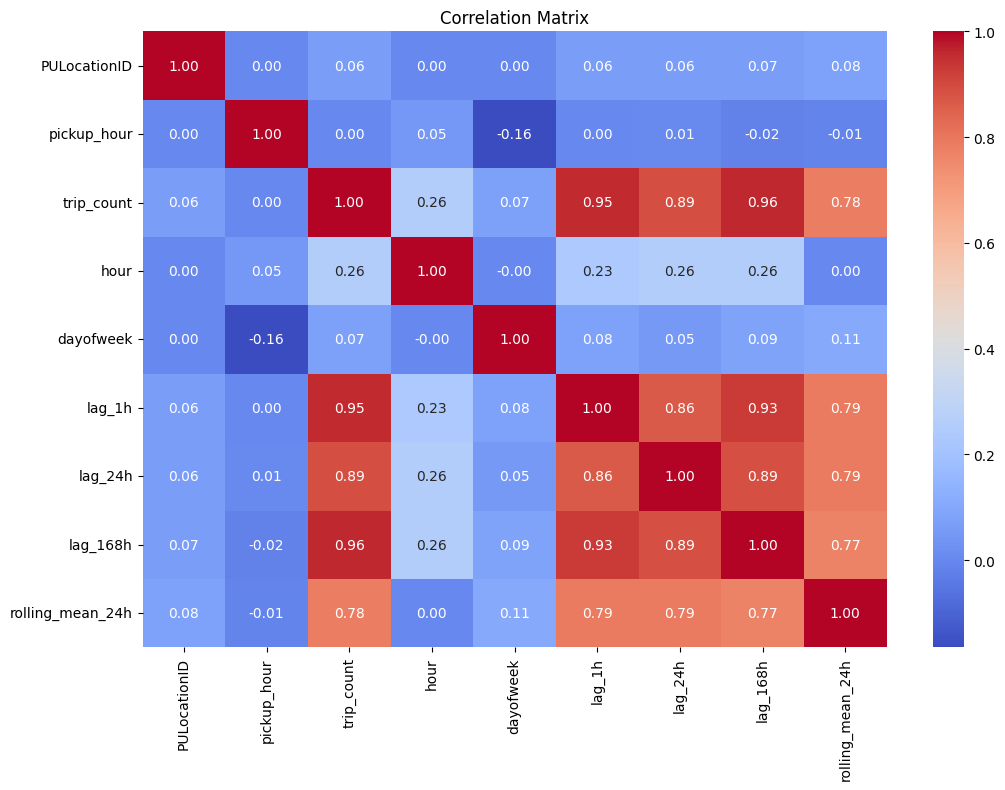

In [10]:
corr_matrix = demand_df.corr()

plt.figure(figsize=(12, 8))

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')

plt.title("Correlation Matrix")
plt.show()

In [11]:
corr_matrix

,PULocationID,pickup_hour,trip_count,hour,dayofweek,lag_1h,lag_24h,lag_168h,rolling_mean_24h
PULocationID,1.000000e+00,9.354730e-13,0.063025,3.566244e-16,4.237449e-16,0.063098,0.063576,0.065415,0.079428
pickup_hour,9.354730e-13,1.000000e+00,0.001799,4.757779e-02,-1.649575e-01,0.000982,0.006042,-0.019203,-0.012026
trip_count,6.302518e-02,1.798867e-03,1.000000,2.563155e-01,7.307084e-02,0.954983,0.892765,0.961369,0.782654
hour,3.566244e-16,4.757779e-02,0.256316,1.000000e+00,-1.898295e-18,0.231181,0.255119,0.257167,0.001974
dayofweek,4.237449e-16,-1.649575e-01,0.073071,-1.898295e-18,1.000000e+00,0.076379,0.053265,0.085242,0.107101
lag_1h,6.309814e-02,9.815169e-04,0.954983,2.311805e-01,7.637899e-02,1.000000,0.864215,0.927911,0.788297
lag_24h,6.357577e-02,6.041516e-03,0.892765,2.551191e-01,5.326452e-02,0.864215,1.000000,0.887813,0.788407
lag_168h,6.541519e-02,-1.920271e-02,0.961369,2.571675e-01,8.524172e-02,0.927911,0.887813,1.000000,0.771376
rolling_mean_24h,7.942766e-02,-1.202598e-02,0.782654,1.974044e-03,1.071009e-01,0.788297,0.788407,0.771376,1.000000


In [12]:
def train_test_split_time_series(data, date_column,test_size):
    min_date = data[date_column].min()
    max_date = data[date_column].max()
    date_definition = min_date + (max_date - min_date) * (1 - test_size)
    X_train = data[data[date_column] < date_definition].drop(labels=['trip_count', 'pickup_hour'], axis=1)
    X_test = data[data[date_column] >= date_definition].drop(labels=['trip_count', 'pickup_hour'], axis=1)

    y_train = data[data[date_column] < date_definition]['trip_count']
    y_test = data[data[date_column] >= date_definition]['trip_count']

    return X_train, X_test, y_train, y_test

In [13]:
X_train, X_test, y_train, y_test = train_test_split_time_series(demand_df.reset_index(), 'pickup_hour', test_size=0.3)

In [14]:
len(X_train), len(X_test), len(y_train), len(y_test)

(92839, 39713, 92839, 39713)

In [15]:
X_train_cat = X_train.copy()
X_test_cat = X_test.copy()
X_train_cat['PULocationID'] = X_train_cat['PULocationID'].astype('category')
X_test_cat['PULocationID'] = X_test_cat['PULocationID'].astype('category')

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

ohe.fit(X_train[['PULocationID']])

# Применяем OHE к train и test
ohe_train_transformed = ohe.transform(X_train[['PULocationID']])
ohe_test_transformed = ohe.transform(X_test[['PULocationID']])

ohe_train_df = pd.DataFrame(ohe_train_transformed, columns=ohe.get_feature_names_out(['PULocationID']), index=X_train.index)
ohe_test_df = pd.DataFrame(ohe_test_transformed, columns=ohe.get_feature_names_out(['PULocationID']), index=X_test.index)

# Объединяем OHE-признаки с остальными, удаляя исходный PULocationID
X_train_ohe = pd.concat([X_train.drop('PULocationID', axis=1), ohe_train_df], axis=1)
X_test_ohe = pd.concat([X_test.drop('PULocationID', axis=1), ohe_test_df], axis=1)

# Проверим размеры
print("Размеры для LightGBM (с 'category'):")
print(f"X_train_cat: {X_train_cat.shape}, X_test_cat: {X_test_cat.shape}")

print("\nРазмеры для LinearReg/XGBoost (с OHE):")
print(f"X_train_ohe: {X_train_ohe.shape}, X_test_ohe: {X_test_ohe.shape}")

Размеры для LightGBM (с 'category'):
X_train_cat: (92839, 8), X_test_cat: (39713, 8)

Размеры для LinearReg/XGBoost (с OHE):
X_train_ohe: (92839, 270), X_test_ohe: (39713, 270)


In [16]:
results = {}

# --- 1. Линейная регрессия (Baseline) ---
print("\n--- Обучение Линейной регрессии ---")
lr_model = LinearRegression()
lr_model.fit(X_train_ohe, y_train)
lr_preds = lr_model.predict(X_test_ohe)

# Оценка
mae_lr = mean_absolute_error(y_test, lr_preds)
rmse_lr = np.sqrt(mean_squared_error(y_test, lr_preds))
r2_lr = r2_score(y_test, lr_preds)

results['Linear Regression'] = {'MAE': mae_lr, 'RMSE': rmse_lr, 'R2 Score': r2_lr}
print("Готово.")

# --- 2. LightGBM ---
print("\n--- Обучение LightGBM ---")
lgbm_model = lgb.LGBMRegressor(random_state=42)
lgbm_model.fit(
    X_train_cat, 
    y_train,
    eval_set=[(X_test_cat, y_test)],
    eval_metric='mae',
    callbacks=[lgb.early_stopping(10, verbose=False)]
)
lgbm_preds = lgbm_model.predict(X_test_cat)

# Оценка
mae_lgbm = mean_absolute_error(y_test, lgbm_preds)
rmse_lgbm = np.sqrt(mean_squared_error(y_test, lgbm_preds))
r2_lgbm = r2_score(y_test, lgbm_preds)

results['LightGBM'] = {'MAE': mae_lgbm, 'RMSE': rmse_lgbm, 'R2 Score': r2_lgbm}
print("Готово.")

# --- 3. XGBoost ---
print("\n--- Обучение XGBoost ---")
# Используем OHE-данные.
xgb_model = xgb.XGBRegressor(
    random_state=42, 
    n_estimators=1000,
    early_stopping_rounds=10
)
xgb_model.fit(
    X_train_ohe, 
    y_train,
    eval_set=[(X_test_ohe, y_test)],
    verbose=False
)
xgb_preds = xgb_model.predict(X_test_ohe)

# Оценка
mae_xgb = mean_absolute_error(y_test, xgb_preds)
rmse_xgb = np.sqrt(mean_squared_error(y_test, xgb_preds))
r2_xgb = r2_score(y_test, xgb_preds)

results['XGBoost'] = {'MAE': mae_xgb, 'RMSE': rmse_xgb, 'R2 Score': r2_xgb}
print("Готово.")


results_df = pd.DataFrame(results).T

# Можно отсортировать по MAE (чем меньше, тем лучше) или по R2 (чем больше, тем лучше)
results_df = results_df.sort_values(by='R2 Score', ascending=False)

print("\n\n--- Сравнение моделей ---")
print(results_df)

# Для контекста добавим среднее значение
print(f"\nСредний спрос на тестовой выборке: {y_test.mean():.2f}")


--- Обучение Линейной регрессии ---
Готово.

--- Обучение LightGBM ---
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1568
[LightGBM] [Info] Number of data points in the train set: 92839, number of used features: 8
[LightGBM] [Info] Start training from score 111.825903
Готово.

--- Обучение XGBoost ---
Готово.


--- Сравнение моделей ---
                         MAE       RMSE  R2 Score
XGBoost            14.566324  28.593556  0.962060
LightGBM           15.020057  28.609978  0.962017
Linear Regression  19.575604  35.890940  0.940224

Средний спрос на те

Теперь можно подавать резюме в яндекс go 😎